# Basketball Playoffs Predictive Model

## Data Understanding/Preparation (??)

After understanding the data meaning we are ready to start processing it. Our first step in this phase is the creation of a SQLite database in order to speed up the data accesses and also to facilitate the joining of data from the various tables.

To fulfil the data needs we defined this schema:

```sql
CREATE TABLE awards_players (
    playerID TEXT,
    award    TEXT,
    year     INTEGER,
    lgID     TEXT,
    CONSTRAINT fk_playerID FOREIGN KEY (
        playerID
    )
    REFERENCES players (bioID) 
);

CREATE TABLE coaches (
    coachID     TEXT,
    year        INTEGER,
    tmID        TEXT,
    lgID        TEXT,
    stint       INTEGER,
    won         INTEGER,
    lost        INTEGER,
    post_wins   INTEGER,
    post_losses INTEGER,
    PRIMARY KEY (
        coachID,
        year,
        tmID,
        stint
    ),
    CONSTRAINT fk_year_tmID FOREIGN KEY (
        year,
        tmID
    )
    REFERENCES teams (year,
    tmID) 
);

CREATE TABLE players (
    bioID        TEXT    PRIMARY KEY,
    pos          TEXT,
    firstseason  INTEGER,
    lastseason   INTEGER,
    height       REAL,
    weight       INTEGER,
    college      TEXT,
    collegeOther TEXT,
    birthDate    TEXT,
    deathDate    TEXT
);

CREATE TABLE players_teams (
    playerID           TEXT,
    year               INTEGER,
    stint              INTEGER,
    tmID               TEXT,
    lgID               TEXT,
    GP                 INTEGER,
    GS                 INTEGER,
    minutes            INTEGER,
    points             INTEGER,
    oRebounds          INTEGER,
    dRebounds          INTEGER,
    rebounds           INTEGER,
    assists            INTEGER,
    steals             INTEGER,
    blocks             INTEGER,
    turnovers          INTEGER,
    PF                 INTEGER,
    fgAttempted        INTEGER,
    fgMade             INTEGER,
    ftAttempted        INTEGER,
    ftMade             INTEGER,
    threeAttempted     INTEGER,
    threeMade          INTEGER,
    dq                 INTEGER,
    PostGP             INTEGER,
    PostGS             INTEGER,
    PostMinutes        INTEGER,
    PostPoints         INTEGER,
    PostoRebounds      INTEGER,
    PostdRebounds      INTEGER,
    PostRebounds       INTEGER,
    PostAssists        INTEGER,
    PostSteals         INTEGER,
    PostBlocks         INTEGER,
    PostTurnovers      INTEGER,
    PostPF             INTEGER,
    PostfgAttempted    INTEGER,
    PostfgMade         INTEGER,
    PostftAttempted    INTEGER,
    PostftMade         INTEGER,
    PostthreeAttempted INTEGER,
    PostthreeMade      INTEGER,
    PostDQ             INTEGER,
    CONSTRAINT fk_playerID FOREIGN KEY (
        playerID
    )
    REFERENCES players (bioID),
    CONSTRAINT fk_year_tmID FOREIGN KEY (
        year,
        tmID
    )
    REFERENCES teams (year,
    tmID) 
);

CREATE TABLE series_post (
    year       INTEGER,
    round      TEXT,
    series     TEXT,
    tmIDWinner TEXT,
    lgIDWinner TEXT,
    tmIDLoser  TEXT,
    lgIDLoser  TEXT,
    W          INTEGER,
    L          INTEGER,
    CONSTRAINT fk_year_tmIDWinner FOREIGN KEY (
        year,
        tmIDWinner
    )
    REFERENCES teams (year,
    tmID),
    CONSTRAINT fk_year_tmIDLoser FOREIGN KEY (
        year,
        tmIDLoser
    )
    REFERENCES teams (year,
    tmID) 
);

CREATE TABLE teams (
    year       INTEGER,
    lgID       TEXT,
    tmID       TEXT,
    franchID   TEXT,
    confID     TEXT,
    divID      TEXT,
    rank       INTEGER,
    playoff    TEXT,
    seeded     INTEGER,
    firstRound TEXT,
    semis      TEXT,
    finals     TEXT,
    name       TEXT,
    o_fgm      INTEGER,
    o_fga      INTEGER,
    o_ftm      INTEGER,
    o_fta      INTEGER,
    o_3pm      INTEGER,
    o_3pa      INTEGER,
    o_oreb     INTEGER,
    o_dreb     INTEGER,
    o_reb      INTEGER,
    o_asts     INTEGER,
    o_pf       INTEGER,
    o_stl      INTEGER,
    o_to       INTEGER,
    o_blk      INTEGER,
    o_pts      INTEGER,
    d_fgm      INTEGER,
    d_fga      INTEGER,
    d_ftm      INTEGER,
    d_fta      INTEGER,
    d_3pm      INTEGER,
    d_3pa      INTEGER,
    d_oreb     INTEGER,
    d_dreb     INTEGER,
    d_reb      INTEGER,
    d_asts     INTEGER,
    d_pf       INTEGER,
    d_stl      INTEGER,
    d_to       INTEGER,
    d_blk      INTEGER,
    d_pts      INTEGER,
    tmORB      INTEGER,
    tmDRB      INTEGER,
    tmTRB      INTEGER,
    opptmORB   INTEGER,
    opptmDRB   INTEGER,
    opptmTRB   INTEGER,
    won        INTEGER,
    lost       INTEGER,
    GP         INTEGER,
    homeW      INTEGER,
    homeL      INTEGER,
    awayW      INTEGER,
    awayL      INTEGER,
    confW      INTEGER,
    confL      INTEGER,
    min        INTEGER,
    attend     INTEGER,
    arena      TEXT,
    PRIMARY KEY (
        year,
        tmID
    )
);
```

Then we populated the database with the provided data.

In [24]:
%matplotlib inline

import subprocess
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sb

import sqlite3
import subprocess

# Create a shell script
# with open('myscript.sh', 'w') as f:
#     f.write('cat ./database/final.sql | sqlite3 ./database/bdfinal.sql')

# Execute the script in WSL
# subprocess.run(["wsl", "./myscript.sh"], check=True,shell=True)

connection = sqlite3.connect("./database/test.db")

### Missing Values

Before we train models on this data we need to assess its quality. One important step is finding missing values.

We will look for missing values in all the created tables.

In [25]:
print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM coaches;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)

print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM players;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)

## ---//---
df = pd.read_sql("SELECT * FROM players;",connection)

col_names = df.columns
for index, row in df.iterrows():
    
    ## iterate through columns
    found = False
    if row["pos"] == "":
        found = True
    elif row["height"] == 0:
        found = True
    elif row["weight"] == 0:
        found = True
    elif row["birthDate"] == "" or row["birthDate"] == "0000-00-00":
        found = True
    elif row["college"] == "":
        found = True

    if(found):
        print(row["bioID"])
    
print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM players_teams;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)

print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM series_post;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)

print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM teams;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)

print("\n=========================================\n")

df = pd.read_sql("SELECT * FROM teams_post;",connection)

null_mask = df.isnull().any(axis=1)
null_rows = df[null_mask]
print(null_rows)



Empty DataFrame
Columns: [coachID, year, tmID, lgID, stint, won, lost, post_wins, post_losses]
Index: []


Empty DataFrame
Columns: [bioID, pos, firstseason, lastseason, height, weight, college, collegeOther, birthDate, deathDate]
Index: []
adamsmi01w
adubari99w
aglerbr99w
alberma01w
allenso99w
amachma01w
ayimmi01w
batkosu01w
beckan99wc
berezva01w
beviltu01w
bibbyhe01w
bibbyje01w
bibrzag01w
bishoab01w
bjedoni01w
boguemu01w
bonfisu01w
bouchke01w
boydca01w
boyerli99w
brancli01w
brogami01w
brownde01w
brucegr99w
bryanjo01w
burgean01w
cartesy01w
castriz01w
chancva99w
chatmda99w
clarkma01w
cleamji01w
coopemi01w
cowenda01w
coylepa99w
cunnima01w
dailesh99w
darscna99w
davista02w
desouer01w
dixonin01w
donovan99w
dossaci01w
dunnli99wc
dunntr01wc
dydekma01w
estessh99w
evansda01w
fallotr01w
feifesu01w
feldeja01w
fernama01w
ferrama01w
fortnne99w
fostecl99w
frankba01w
frohlli01w
gaineco01w
garcibe01w
gilbrbr01w
givench01w
gomisem01w
grafca99wc
grginve01w
grubigo01w
grudasa01w
hagiwmi01w
hamzoro01w


### Player

- After a quick glance at the data, it's easy to see that there's a certain amount of players that have many important missing/null values (college, height and weight).

In [26]:
dataframe = pd.read_sql("select bioID from players where weight = 0 or height = 0 or college = '' or pos = '';", connection)
print(dataframe)

          bioID
0    adamsmi01w
1    adubari99w
2    aglerbr99w
3    alberma01w
4    allenso99w
..          ...
203  zakalok01w
204   zarafr01w
205  zhengha01w
206  zierddo99w
207  zirkozu01w

[208 rows x 1 columns]


- Lets check if any of these players with a null position are actually coaches, since the awards_players tables has a coach award and references the players table.

In [27]:
# select count(*) from players where pos = "";
# execute the query
df = pd.read_sql("select count(*) from players where pos = '';",connection)
num_players = df.values[0][0]
print(num_players)

# select count(*) from players where pos = "" and bioID in (select coachID from coaches);
# execute the query
df = pd.read_sql("select count(*) from players where pos = '' and bioID in (select coachID from coaches);",connection)
num_players = df.values[0][0]
print(num_players)


78
52


- 52 out of the 78 players without position are coaches

- From these 208 players, it's important to see which actually were a part of a team

In [28]:
active_missing_values_players = pd.read_sql("select distinct(bioID), weight, height, pos from players where (weight = 0 or height = 0) and pos <> ''", connection)
print(active_missing_values_players)

         bioID  weight  height  pos
0   alberma01w       0    64.0    G
1    ayimmi01w       0    75.0    F
2   berezva01w       0    76.0    C
3   bishoab01w       0    74.0  F-C
4   brancli01w       0    64.0    G
5   cartesy01w       0    66.0    G
6   clarkma01w       0    75.0  F-C
7   cunnima01w       0    76.0  F-C
8   davista02w       0    71.0    G
9   dixonin01w       0    75.0    C
10  evansda01w       0    67.0    G
11  feldeja01w       0    73.0    F
12  frankba01w       0     0.0  F-C
13  gilbrbr01w       0    73.0    G
14  givench01w       0    70.0    G
15  hayesti01w       0    70.0    G
16  hemmera01w       0    75.0  F-C
17  hodgesa01w       0    69.0  F-G
18  ibekwif01w       0    74.0    F
19  johnssh02w       0    71.0    G
20    listr01w       0    70.0  G-F
21  maytuet01w       0    72.0    F
22  millebr01w       0    76.0    C
23  mokanch01w       0    77.0    F
24  morgale01w       0    73.0    F
25  morrich01w       0     0.0    F
26  morrizi01w       0    76

- Regarding these 83 players, if a player doesn't have their position missing, we decided to replace their missing weight and/or height values with the average value of the players of their same position. 

    - Obtain the average weight and height for each player position:

In [29]:
# query para cada valor
avg_pos_weights = pd.read_sql("select pos, avg(weight) from players where weight <> 0 group by pos;", connection)
print(avg_pos_weights)
avg_pos_heights = pd.read_sql("select pos, avg(height) from players where height <> 0 group by pos;", connection)
print(avg_pos_heights)

   pos  avg(weight)
0    C   196.975000
1  C-F   191.111111
2    F   174.018265
3  F-C   184.800000
4  F-G   159.909091
5    G   148.046823
6  G-F   163.764706
   pos  avg(height)
0    C    75.707692
1  C-F    75.333333
2    F    73.397380
3  F-C    75.188406
4  F-G    71.916667
5    G    68.540453
6  G-F    71.527273



- Store the values in two dictionaries, where the key values are the players' positions

In [30]:
# add to a dictionary where the key are the positions and the values are the avg weights
avg_weights = {}

for index, row in avg_pos_weights.iterrows():
    avg_weights[row["pos"]] = row["avg(weight)"]
    
print(avg_weights)

avg_heights = {}

for index, row in avg_pos_heights.iterrows():
    avg_heights[row["pos"]] = row["avg(height)"]
    
print(avg_heights)

{'C': 196.975, 'C-F': 191.11111111111111, 'F': 174.01826484018264, 'F-C': 184.8, 'F-G': 159.9090909090909, 'G': 148.04682274247492, 'G-F': 163.76470588235293}
{'C': 75.70769230769231, 'C-F': 75.33333333333333, 'F': 73.39737991266375, 'F-C': 75.18840579710145, 'F-G': 71.91666666666667, 'G': 68.54045307443366, 'G-F': 71.52727272727273}


In [31]:

for index, row in active_missing_values_players.iterrows():
    player = pd.read_sql("select * from players where bioID = '" + row["bioID"] + "';", connection)

    
    pos = player["pos"].values[0]
    if pos == '':
        continue
    
    if(player["weight"].values[0] != 0 and player["height"].values[0] != 0):
        # print("Player already has values")
        # print(player)
        continue
    
    print("\n===\n")

    ## get average values for the player's position pos
    if(player["weight"].values[0] == 0):
        weight = avg_weights[pos]
    else:
        weight = player["weight"].values[0]
    if (player["height"].values[0] == 0):
        height = avg_heights[pos]
    else:
        height = player["height"].values[0]

    
    
    ## get row index
    pos = row.index[0]
    
    # update player's height and weight
    print("UPDATE players SET height = '" + str(height) + "', weight = '" + str(weight) + "' WHERE bioID = '" + player["bioID"].values[0] + "';")
    
    # update player's height and weight
    connection.execute("UPDATE players SET height = " + str(height) + ", weight = " + str(weight) + " WHERE bioID = '" + player["bioID"].values[0] + "';")
    connection.commit()
    


===

UPDATE players SET height = '64.0', weight = '148.04682274247492' WHERE bioID = 'alberma01w';

===

UPDATE players SET height = '75.0', weight = '174.01826484018264' WHERE bioID = 'ayimmi01w';

===

UPDATE players SET height = '76.0', weight = '196.975' WHERE bioID = 'berezva01w';

===

UPDATE players SET height = '74.0', weight = '184.8' WHERE bioID = 'bishoab01w';

===

UPDATE players SET height = '64.0', weight = '148.04682274247492' WHERE bioID = 'brancli01w';

===

UPDATE players SET height = '66.0', weight = '148.04682274247492' WHERE bioID = 'cartesy01w';

===

UPDATE players SET height = '75.0', weight = '184.8' WHERE bioID = 'clarkma01w';

===

UPDATE players SET height = '76.0', weight = '184.8' WHERE bioID = 'cunnima01w';

===

UPDATE players SET height = '71.0', weight = '148.04682274247492' WHERE bioID = 'davista02w';

===

UPDATE players SET height = '75.0', weight = '196.975' WHERE bioID = 'dixonin01w';

===

UPDATE players SET height = '67.0', weight = '148.046822

# Outliers

Now lets check if there are any outliers in the data

## Player

In this table we will be looking for outliers in weight, height and birth dates.

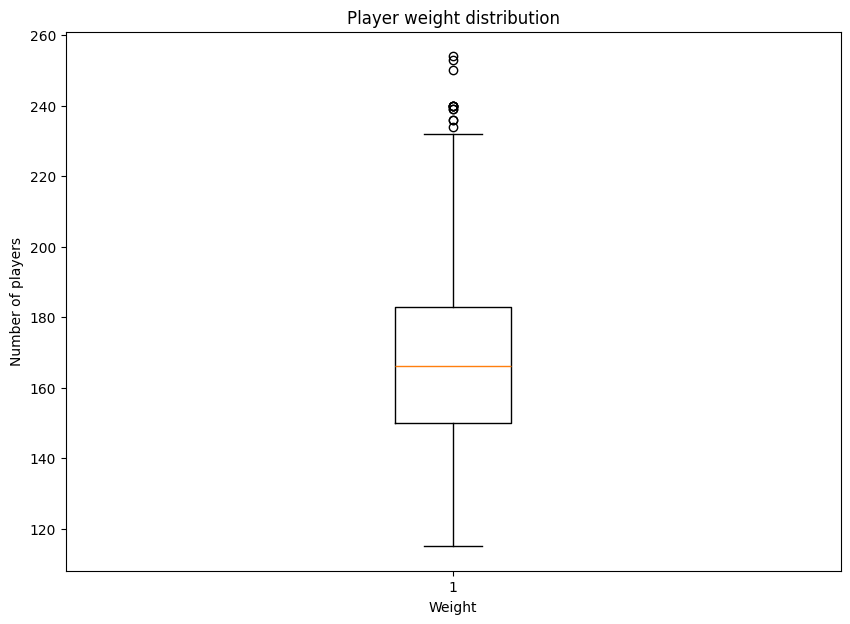

In [32]:
# graph with player weight distribution
df = pd.read_sql("SELECT weight FROM players;",connection)
df = df[df.weight != 0]

plt.figure(figsize=(10, 7))
plt.title("Player weight distribution")
plt.xlabel("Weight")
plt.ylabel("Number of players")
plt.boxplot(df["weight"])
plt.show()


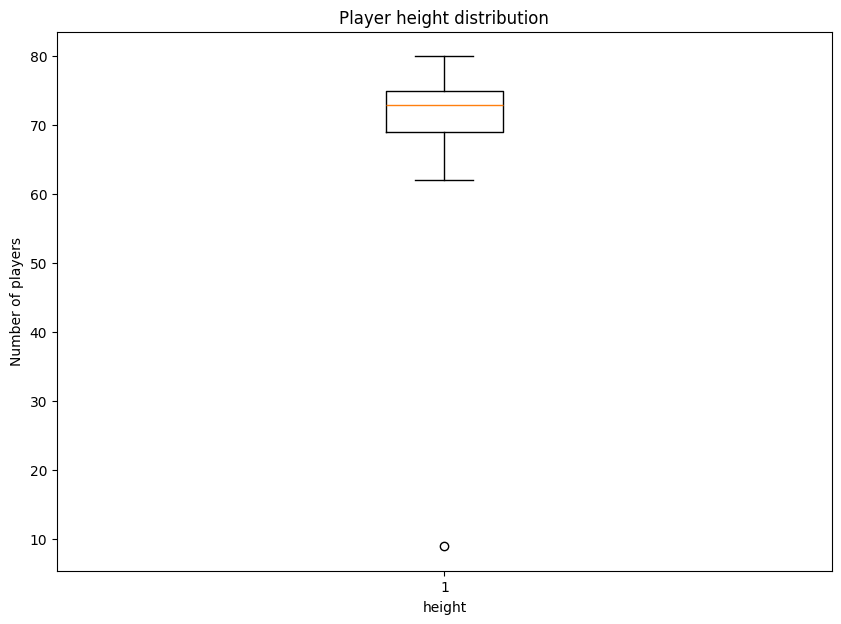

In [33]:
# graph with player height distribution
df = pd.read_sql("SELECT height FROM players;",connection)
df = df[df.height != 0]

plt.figure(figsize=(10, 7))
plt.title("Player height distribution")
plt.xlabel("height")
plt.ylabel("Number of players")
plt.boxplot(df["height"])
plt.show()

We can verify that there is one player with a height of 9.0. We can fix this via mean imputation, which means that her height will be replaced by the average height of the players that play in the same position as her.

In [34]:
# select player with height < 20
df = pd.read_sql("SELECT * FROM players WHERE height < 20 and height > 0;",connection)

# get the average height for the player's position
average_height = avg_heights[df["pos"].values[0]]

# update player's height
connection.execute("UPDATE players SET height = " + str(average_height) + " WHERE bioID = '" + df["bioID"].values[0] + "';")
connection.commit()

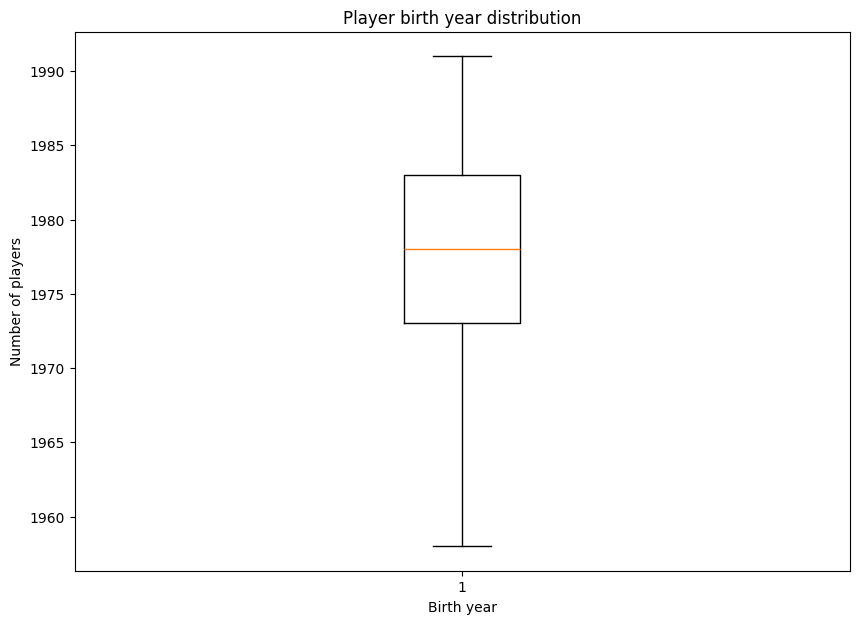

In [35]:
# graph with player birth year distribution
df = pd.read_sql("SELECT birthDate FROM players;",connection)
df = df[df.birthDate != "0000-00-00"]

#convert birthdate to year
df["birthDate"] = pd.to_datetime(df["birthDate"])
df["birthDate"] = df["birthDate"].dt.year

plt.figure(figsize=(10, 7))
plt.title("Player birth year distribution")
plt.xlabel("Birth year")
plt.ylabel("Number of players")
plt.boxplot(df["birthDate"])
plt.show()

## Inconsistent data

### Player Awards

- Check if there's any award, that should be given to one player, is given to two or more players.

In [36]:
dataframe = pd.read_sql(" select count(playerID), award, year from awards_players group by award, year;", connection)

# print rows 
print(dataframe)

    count(playerID)                               award  year
0                 1  All-Star Game Most Valuable Player     1
1                 1  All-Star Game Most Valuable Player     2
2                 1  All-Star Game Most Valuable Player     3
3                 1  All-Star Game Most Valuable Player     4
4                 1  All-Star Game Most Valuable Player     6
..              ...                                 ...   ...
76                1    WNBA Finals Most Valuable Player     6
77                1    WNBA Finals Most Valuable Player     7
78                1    WNBA Finals Most Valuable Player     8
79                1    WNBA Finals Most Valuable Player     9
80                1    WNBA Finals Most Valuable Player    10

[81 rows x 3 columns]


However, we noticed that there's an award missing part of its title. Therefore, we'll have to fix it.

In [37]:
connection.execute("UPDATE awards_players SET award = 'Kim Perrot Sportsmanship Award' WHERE award = 'Kim Perrot Sportsmanship';")
connection.commit()

### Teams Post

- Check if, in any year, no more than 8 teams passed to the playoffs.

In [ ]:
dataframe = pd.read_sql("select count(tmID) as num, year from teams_post group by year having num > 8;", connection)
print(dataframe)

- Check if, in any year, only one team won the playoff.

In [ ]:
dataframe = pd.read_sql("select year, tmID, finals from teams where finals = 'W' order by year;", connection)
print(dataframe)

### Teams

- Check if the sum of games won and lost by a player is equal to the total games played by a team

In [ ]:
dataframe = pd.read_sql("select year, tmID, won, lost, GP, (won + lost) as Games from teams where Games <> GP;", connection)
print(dataframe)

- Check if the sum of rebounds made by a team is equal to the sum of offensive rebounds and defensive rebounds

In [ ]:
dataFrame = pd.read_sql("select year, tmID, o_oreb, o_dreb, o_reb, (o_oreb + o_dreb) as rebounds from teams where o_reb <> rebounds;", connection)
print(dataFrame)
print("===============================")

dataFrame = pd.read_sql("select year, tmID, d_oreb, d_dreb, d_reb, (d_oreb + d_dreb) as rebounds from teams where d_reb <> rebounds;", connection)
print(dataFrame)

- Check if the stats (field goals, 3 pointers, free throws, etc.) attempted are in a bigger quantity than the stats made

In [ ]:
dataframe = pd.read_sql("select year, tmID from teams where o_fgm > o_fga;", connection)
print(dataframe)
print("===============================")

dataframe = pd.read_sql("select year, tmID from teams where o_ftm > o_fta;", connection)
print(dataframe)
print("===============================")

dataframe = pd.read_sql("select year, tmID from teams where o_3pm > o_3pa;", connection)
print(dataframe)
print("===============================")

dataframe = pd.read_sql("select year, tmID from teams where d_fgm > d_fga;", connection)
print(dataframe)
print("===============================")

dataframe = pd.read_sql("select year, tmID from teams where d_ftm > d_fta;", connection)
print(dataframe)
print("===============================")

dataframe = pd.read_sql("select year, tmID from teams where d_3pm > d_3pa;", connection)
print(dataframe)
print("===============================")


## Removing irrelevant Columns

Columns that are entirely composed by missing values can be removed. The league id column can also be dropped since the entire dataset belongs to the same league.

In [38]:
# remove tmORB, tmDRB, tmTRB, opptmORB, opptmDRB, opptmTRB from teams using a query
connection.execute("ALTER TABLE teams DROP COLUMN tmORB;")
connection.execute("ALTER TABLE teams DROP COLUMN tmDRB;")
connection.execute("ALTER TABLE teams DROP COLUMN tmTRB;")
connection.execute("ALTER TABLE teams DROP COLUMN opptmORB;")
connection.execute("ALTER TABLE teams DROP COLUMN opptmDRB;")
connection.execute("ALTER TABLE teams DROP COLUMN opptmTRB;")

# remove franchID and lgID from teams using a query
connection.execute("ALTER TABLE teams DROP COLUMN franchID;")
connection.execute("ALTER TABLE teams DROP COLUMN lgID;")

In [39]:
# remove firstSeason and lastSeason from players using a query
connection.execute("ALTER TABLE players DROP COLUMN firstSeason;")
connection.execute("ALTER TABLE players DROP COLUMN lastSeason;")

In [40]:
#remove lgIDWinner, lgIDLoser and series from series_post using a query
connection.execute("ALTER TABLE series_post DROP COLUMN lgIDWinner;")
connection.execute("ALTER TABLE series_post DROP COLUMN lgIDLoser;")
connection.execute("ALTER TABLE series_post DROP COLUMN series;")

In [41]:
#remove lgID from teams_post using a query
connection.execute("ALTER TABLE teams_post DROP COLUMN lgID;")

#remove lgID from awards_players using a query
connection.execute("ALTER TABLE awards_players DROP COLUMN lgID;")

#remove lgID from players_teams using a query
connection.execute("ALTER TABLE players_teams DROP COLUMN lgID;")

In [42]:
#remove lgID from coaches using a query
connection.execute("ALTER TABLE coaches DROP COLUMN lgID;")

In [ ]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression

# remove confID and divID from teams using a query
# connection.execute("ALTER TABLE teams DROP COLUMN confID;")
# connection.execute("ALTER TABLE teams DROP COLUMN divID;")
# connection.commit()

# get data
df = pd.read_sql("select * from players join players_teams on players.bioID = players_teams.playerID;", connection)

columns = ['bioID', 'pos', 'height', 'weight', 'college', 'collegeOther',
       'birthDate', 'year', 'stint', 'tmID', 'points', 'oRebounds', 'dRebounds', 'rebounds',
       'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted',
       'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade']

df = df[columns]

# get bioID and year from the dataframe
bioID = df["bioID"].values
year = df["year"].values

iterable = zip(bioID, year)

# iterate through the (bioID, year) pairs

for bioID, year in iterable:
        # get number of awards for the player in the team in the year
        query = "select count(award) as num_awards_player from awards_players ap join players_teams pt on ap.year = pt.year \
                and ap.playerID = pt.playerID where ap.playerID = '" + bioID + "' and ap.year <= " + str(year) + ";"
                
        player_awards = pd.read_sql(query, connection)
        
        # if(player_awards["num_awards_player"].values[0] > 0):
        #         print(bioID, year, player_awards)
                
        # add number of awards to the dataframe
        df.loc[(df["bioID"] == bioID) & (df["year"] == year), "num_awards_player"] = player_awards["num_awards_player"].values[0]
     
# extract year from birthDate
df["birthDate"] = pd.to_datetime(df["birthDate"])
df["birthDate"] = df["birthDate"].dt.year

player_ids_10 = df[df["year"] == 10]["bioID"].values

In [ ]:
# transform categorical data
categorical_columns = ['bioID', 'pos', 'college', 'collegeOther', 'tmID']
for col in categorical_columns:
    df[col] = df[col].astype('category')
    
df = pd.get_dummies(df, columns=categorical_columns)

print(df['birthDate'])

# # get all rows from df where year = 10
test_data = df.loc[df["year"] == 10]

# # get all rows from df where year <> 10
train_data = df.loc[df["year"] < 10]


labels = ['points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted',
       'ftMade', 'threeAttempted', 'threeMade']

inputs = []

for col in train_data.columns:
    if col not in labels:
        inputs.append(col)

print(inputs)

train_inputs = train_data[inputs].values
train_labels = train_data[labels].values

test_inputs = test_data[inputs].values
test_labels = test_data[labels].values

# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
test_inputs = scaler.transform(test_inputs)

In [ ]:
# train model
model = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 100, 100), 
    max_iter=2000,batch_size=32, alpha=0.0001, solver='adam', verbose=10, random_state=21, tol=0.000000001))
model.fit(train_inputs, train_labels)

# test model
predictions = model.predict(test_inputs)
print(predictions)

In [ ]:
# convert all predictions to integers
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        predictions[i][j] = int(round(predictions[i][j]))

for i in range(len(predictions)):
    # print("player: ", i)
    print("player: ", player_ids_10[i])
    for j in range(len(predictions[i])):
        print(labels[j], ":  predicted: ", predictions[i][j], " actual: ", test_labels[i][j])
    print("\n")


In [ ]:
# get team ids from the dataframe from all years 
team_ids = set(df["tmID"].values)

# create a dictionary where the keys are the team ids and the values are the avg stats for the team
avg_team_stats = {}

for team_id in team_ids:
    avg_team_stats[team_id] = [0] * len(labels)
    
print(test_data.columns)

# iterate through the team ids
for team_id in team_ids:
    
    for i in range(len(predictions)):
 
        if(test_data["tmID_" + team_id].values[i] == 1):
            avg_team_stats[team_id] = [x + y for x, y in zip(avg_team_stats[team_id], predictions[i])]
            
        
# remove tmID from the dictionary that contain all the avg stats for the teams at 0
for team_id in team_ids:
    if(avg_team_stats[team_id] == [0] * len(labels)):
        del avg_team_stats[team_id]
        
        
print(avg_team_stats)

In [ ]:
query = "select * from teams where year <> 11;"

team_stats = pd.read_sql(query, connection)

columns = ['tmID', 'year','o_pts', 'o_oreb', 'o_dreb', 'o_reb', 'o_asts', 'o_stl',
       'o_blk', 'o_to', 'o_pf', 'o_fga', 'o_fgm', 'o_fta',
       'o_ftm', 'o_3pa', 'o_3pm', 'confID', 'playoff']

team_stats = team_stats[columns]

query = "select tmID from teams where year = 10;"
team_ids = pd.read_sql(query, connection)
team_ids = team_ids["tmID"].values

team_stats = team_stats.drop(columns=["tmID"])

categorical_columns = ['confID']

for col in categorical_columns:
       team_stats[col] = team_stats[col].astype('category')
       
team_stats = pd.get_dummies(team_stats, columns=categorical_columns)

In [ ]:
labels = ['playoff']
inputs = []

for col in team_stats.columns:
    if col not in labels:
        inputs.append(col)

train_data = team_stats.loc[team_stats["year"] != 10]

print(train_data.columns)

test_data = team_stats.loc[team_stats["year"] == 10]

# drop year column from train and test data
train_data = train_data.drop(columns=["year"])
test_data = test_data.drop(columns=["year"])

# drop year from inputs
inputs.remove("year")

train_inputs = train_data[inputs].values
train_labels = train_data[labels].values

test_inputs= []

for team_id in avg_team_stats:
    # append confID to the list
    
    query = "select confID from teams where tmID = '" + team_id + "';"
    confID = pd.read_sql(query, connection)
    confID = confID["confID"].values[0]
    
    avg_team_stats[team_id].append(confID == 'EA')
    avg_team_stats[team_id].append(confID == 'WE')
    
    test_inputs.append(avg_team_stats[team_id])
    
    
test_labels = test_data[labels].values

print(test_inputs)
print(test_labels)

### Logistic Regression

In [ ]:
# logistic regression
from sklearn.metrics import confusion_matrix

logreg = LogisticRegression(max_iter=1000)
logreg.fit(train_inputs,train_labels)

y_pred = logreg.predict(test_inputs)

print(train_inputs)
print(test_inputs)


#print metrics
print("Accuracy:",metrics.accuracy_score(test_labels,y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred, pos_label="Y"))
print("Recall:",metrics.recall_score(test_labels, y_pred, pos_label="Y"))
print("F1:",metrics.f1_score(test_labels, y_pred, pos_label="Y"))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'
plt.title(all_sample_title, size = 10)
plt.show()

query = "select tmId, confID from teams where year = 10;"
teams_conf_ids = pd.read_sql(query, connection)

query = "select tmID from teams where year = 10;"

# print(teams_conf_ids)

west_teams = teams_conf_ids[teams_conf_ids["confID"] == "WE"]
east_teams = teams_conf_ids[teams_conf_ids["confID"] == "EA"]

# print(west_teams)
# print(east_teams)

# print the probabilities for each class
probs = logreg.predict_proba(test_inputs)
probs_west = []
probs_east = []

for i in range(len(probs)):
    team_id = team_ids[i]
    
    if team_id in west_teams["tmID"].values:
        probs_west.append((team_id, probs[i][1]))
        
    if team_id in east_teams["tmID"].values:
        probs_east.append((team_id, probs[i][1]))
    
    # print(f"{team_name[0]}: {probs[i][1]}")

probs_west = sorted(probs_west, key=lambda x: x[1], reverse=True)
probs_east = sorted(probs_east, key=lambda x: x[1], reverse=True)

print(probs_west)
print(probs_east)

### Neural Network

In [ ]:
# neural network

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, alpha=0.0001, solver='adam', verbose=0, random_state=21, tol=0.000000001)
mlp.fit(train_inputs,train_labels)

y_pred = mlp.predict(test_inputs)
#print metrics
print("Accuracy:",metrics.accuracy_score(test_labels,y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred, pos_label="Y"))

print("Recall:",metrics.recall_score(test_labels, y_pred, pos_label="Y"))
print("F1:",metrics.f1_score(test_labels, y_pred, pos_label="Y"))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'
plt.title(all_sample_title, size = 10)
plt.show()

# print the probabilities for each class
probs = mlp.predict_proba(test_inputs)
probs_west = []
probs_east = []

for i in range(len(probs)):
    team_id = team_ids[i]
    
    if team_id in west_teams["tmID"].values:
        probs_west.append((team_id, probs[i][1]))
        
    if team_id in east_teams["tmID"].values:
        probs_east.append((team_id, probs[i][1]))
    
    # print(f"{team_name[0]}: {probs[i][1]}")
    
probs_west = sorted(probs_west, key=lambda x: x[1], reverse=True)
probs_east = sorted(probs_east, key=lambda x: x[1], reverse=True)

print(probs_west)
print(probs_east)

### Support Vector Machine (SVM)

In [ ]:
# SVM

from sklearn import svm

clf = svm.SVC(kernel='linear', C=1, probability=True)
clf.fit(train_inputs,train_labels)

y_pred = clf.predict(test_inputs)

#print metrics
print("Accuracy:",metrics.accuracy_score(test_labels,y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred, pos_label="Y"))
print("Recall:",metrics.recall_score(test_labels, y_pred, pos_label="Y"))
print("F1:",metrics.f1_score(test_labels, y_pred, pos_label="Y"))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'

plt.title(all_sample_title, size = 10)
plt.show()

# print the probabilities for each class
probs = clf.predict_proba(test_inputs)
probs_west = []
probs_east = []

for i in range(len(probs)):
    
    team_id = team_ids[i]
    
    if team_id in west_teams["tmID"].values:
        probs_west.append((team_id, probs[i][1]))
        
    if team_id in east_teams["tmID"].values:
        probs_east.append((team_id, probs[i][1]))
    
    # print(f"{team_name[0]}: {probs[i][1]}")
    
probs_west = sorted(probs_west, key=lambda x: x[1], reverse=True)
probs_east = sorted(probs_east, key=lambda x: x[1], reverse=True)

print(probs_west)
print(probs_east)

### K-Nearest Neighbour

In [ ]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=24)
knn.fit(train_inputs,train_labels)

y_pred = knn.predict(test_inputs)

#print metrics
print("Accuracy:",metrics.accuracy_score(test_labels,y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred, pos_label="Y"))
print("Recall:",metrics.recall_score(test_labels, y_pred, pos_label="Y"))
print("F1:",metrics.f1_score(test_labels, y_pred, pos_label="Y"))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'

plt.title(all_sample_title, size = 10)
plt.show()

# print the probabilities for each class
probs = knn.predict_proba(test_inputs)
probs_west = []
probs_east = []

for i in range(len(probs)):
    
    team_id = team_ids[i]
    
    if team_id in west_teams["tmID"].values:
        probs_west.append((team_id, probs[i][1]))
        
    if team_id in east_teams["tmID"].values:
        probs_east.append((team_id, probs[i][1]))
    
    # print(f"{team_name[0]}: {probs[i][1]}")
    
probs_west = sorted(probs_west, key=lambda x: x[1], reverse=True)
probs_east = sorted(probs_east, key=lambda x: x[1], reverse=True)

print(probs_west)
print(probs_east)

### Decision Tree

In [ ]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(train_inputs,train_labels)

#print decision tree
tree.plot_tree(dt)
columns = ['bioID', 'pos', 'height', 'weight', 'college', 'collegeOther',
       'birthDate', 'year', 'stint', 'tmID', 'points', 'oRebounds', 'dRebounds', 'rebounds',
       'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted',
       'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade']

y_pred = dt.predict(test_inputs)

#print metrics
print("Accuracy:",metrics.accuracy_score(test_labels,y_pred))
print("Precision:",metrics.precision_score(test_labels, y_pred, pos_label="Y"))
print("Recall:",metrics.recall_score(test_labels, y_pred, pos_label="Y"))
print("F1:",metrics.f1_score(test_labels, y_pred, pos_label="Y"))

# confusion matrix
confusion = confusion_matrix(test_labels, y_pred)
print(f"Confusion matrix:\n{confusion}")

#plot confusion matrix
plt.figure(figsize=(5,5))
sb.heatmap(confusion, annot=True, fmt="g", linewidths=.5, square = True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
all_sample_title = 'Passed to the playoffs?'

plt.title(all_sample_title, size = 10)
plt.show()

# print the probabilities for each class
probs = dt.predict_proba(test_inputs)
probs_west = []
probs_east = []

for i in range(len(probs)):
        
        team_id = team_ids[i]
        
        if team_id in west_teams["tmID"].values:
            probs_west.append((team_id, probs[i][1]))
            
        if team_id in east_teams["tmID"].values:
            probs_east.append((team_id, probs[i][1]))
        
        # print(f"{team_name[0]}: {probs[i][1]}")
        
probs_west = sorted(probs_west, key=lambda x: x[1], reverse=True)
probs_east = sorted(probs_east, key=lambda x: x[1], reverse=True)

## Season 11 

The first step in this part is adding the season 11 data to the database
        # if(player_awards["num_awards_player"].values[0] > 0):
        #         print(bioID, year, player_awards)
                
        # add number of awards to the dataframe
        df.loc[(df["bioID"] == bioID) & (df["year"] == year), "num_awards_player"] = player_awards["num_awards_player"].values[0]
     
# extract year from birthDate
df["birthDate"] = pd.to_datetime(df["birthDate"])
df["birthDate"] = df["birthDate"].dt.year

player_ids_10 = df[df["year"] == 10]["bioID"].values

In [ ]:
# transform categorical data
categorical_columns = ['bioID', 'pos', 'college', 'collegeOther', 'tmID']
for col in categorical_columns:
    df[col] = df[col].astype('category')
    
df = pd.get_dummies(df, columns=categorical_columns)

print(df['birthDate'])

# # get all rows from df where year = 10
test_data = df.loc[df["year"] == 10]

# # get all rows from df where year <> 10
train_data = df.loc[df["year"] < 10]


labels = ['points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted',
       'ftMade', 'threeAttempted', 'threeMade']

inputs = []

for col in train_data.columns:
    if col not in labels:
        inputs.append(col)

print(inputs)

train_inputs = train_data[inputs].values
train_labels = train_data[labels].values

test_inputs = test_data[inputs].values
test_labels = test_data[labels].values

# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
test_inputs = scaler.transform(test_inputs)

In [ ]:
# train model
model = MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=2000,batch_size=32, alpha=0.0001, solver='adam', verbose=10, random_state=21, tol=0.000000001))
model.fit(train_inputs, train_labels)

# test model
predictions = model.predict(test_inputs)
print(predictions)

In [ ]:
# convert all predictions to integers
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        predictions[i][j] = int(round(predictions[i][j]))

for i in range(len(predictions)):
    # print("player: ", i)
    print("player: ", player_ids_10[i])
    for j in range(len(predictions[i])):
        print(labels[j], ":  predicted: ", predictions[i][j], " actual: ", test_labels[i][j])
    print("\n")


In [ ]:
# try neuronal model 
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# remove confID and divID from teams using a query
connection.execute("ALTER TABLE teams DROP COLUMN confID;")
connection.execute("ALTER TABLE teams DROP COLUMN divID;")
connection.commit()

# get data
df = pd.read_sql("select * from teams;", connection)
print(df.columns)

# transform categorical data
categorical_columns = ["tmID", "firstRound", "semis", "finals","name","arena"]
for col in categorical_columns:
    df[col] = df[col].astype('category')
    
df = pd.get_dummies(df, columns=categorical_columns)

print(df.columns)

# get inputs and outputs
inputs = df.loc[:, df.columns != "playoff"].values
labels = df["playoff"].values

# split data
train_inputs, test_inputs, train_labels, test_labels = train_test_split(inputs, labels, test_size=0.3, random_state=1)

# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
test_inputs = scaler.transform(test_inputs)

# create model
model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=2000,batch_size=32, alpha=0.0001, solver='adam', verbose=10, random_state=21, tol=0.000000001)
model.fit(train_inputs, train_labels)

# predict
predictions = model.predict(test_inputs)

# print results
print("Accuracy:", accuracy_score(test_labels, predictions))
print("Confusion Matrix:\n", confusion_matrix(test_labels, predictions))
print("Classification Report:\n", classification_report(test_labels, predictions))

In [ ]:
# add the season 11 data to the database

# get the data from the csv file
df = pd.read_csv("./season11/coaches.csv")

# iterate through each row and add the data to the database
for index, row in df.iterrows():
        
    # add the row to the database
    connection.execute("INSERT INTO coaches (coachID, year, tmID, stint) VALUES ('" + row[0] + "', '" + str(row[1]) + "', '" + row[2] +  "', '" + str(row[4]) + "');")
    connection.commit()


In [ ]:
# add the season 11 data to the database

# get the data from the csv file
df = pd.read_csv("./season11/teams.csv")

# iterate through each row and add the data to the database
for index, row in df.iterrows():
        
    # add the row to the database
    connection.execute("INSERT INTO teams (year, tmID, confID, name, arena) VALUES ('" + str(row[0]) + "', '" + row[2] + "', '" + row[4] +  "', '" + row[5] + "', '" + row[6] + "');")
    connection.commit()

In [ ]:
# add the season 11 data to the database

# get the data from the csv file
df = pd.read_csv("./season11/players_teams.csv")

# iterate through each row and add the data to the database
for index, row in df.iterrows():
        
    # add the row to the database
    connection.execute("INSERT INTO players_teams (playerID, year, stINTEGER, tmID) VALUES ('" + row[0] + "', '" + str(row[1]) + "', '" + str(row[2]) +  "', '" + row[3] + "');")
    connection.commit()

In [ ]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression

# remove confID and divID from teams using a query
# connection.execute("ALTER TABLE teams DROP COLUMN confID;")
# connection.execute("ALTER TABLE teams DROP COLUMN divID;")
# connection.commit()

# get data
df = pd.read_sql("select * from players join players_teams on players.bioID = players_teams.playerID;", connection)

columns = ['bioID', 'pos', 'height', 'weight', 'college', 'collegeOther',
       'birthDate', 'year', 'stint', 'tmID', 'points', 'oRebounds', 'dRebounds', 'rebounds',
       'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted',
       'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade']

df = df[columns]

# get bioID and year from the dataframe
bioID = df["bioID"].values
year = df["year"].values

iterable = zip(bioID, year)

# iterate through the (bioID, year) pairs

for bioID, year in iterable:
        # get number of awards for the player in the team in the year
        query = "select count(award) as num_awards_player from awards_players ap join players_teams pt on ap.year = pt.year \
                and ap.playerID = pt.playerID where ap.playerID = '" + bioID + "' and ap.year <= " + str(year) + ";"
                
        player_awards = pd.read_sql(query, connection)
        
        # if(player_awards["num_awards_player"].values[0] > 0):
        #         print(bioID, year, player_awards)
                
        # add number of awards to the dataframe
        df.loc[(df["bioID"] == bioID) & (df["year"] == year), "num_awards_player"] = player_awards["num_awards_player"].values[0]
     
# extract year from birthDate
df["birthDate"] = pd.to_datetime(df["birthDate"])
df["birthDate"] = df["birthDate"].dt.year

player_ids_11 = df[df["year"] == 11]["bioID"].values

In [ ]:
# transform categorical data
categorical_columns = ['bioID', 'pos', 'college', 'collegeOther', 'tmID']
for col in categorical_columns:
    df[col] = df[col].astype('category')
    
df = pd.get_dummies(df, columns=categorical_columns)

print(df)
# # get all rows from df where year = 11
test_data = df.loc[df["year"] == 11]

print(test_data)

# # get all rows from df where year <> 11
train_data = df.loc[df["year"] != 11]


labels = ['points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted',
       'ftMade', 'threeAttempted', 'threeMade']

inputs = []

for col in train_data.columns:
    if col not in labels:
        inputs.append(col)

# print(inputs)

train_inputs = train_data[inputs].values
train_labels = train_data[labels].values

test_inputs = test_data[inputs].values
test_labels = test_data[labels].values

# scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
test_inputs = scaler.transform(test_inputs)